# Similarity-Based Production Prediction

This notebook builds a KNN model to predict production based on:
- **Image embeddings**: 512-dimensional vectors representing visual similarity
- **Categorical features**: Product attributes (family, category, fabric, color, etc.)
- **K-Nearest Neighbors**: Find similar past products and predict based on their production

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [28]:
# Load train and test data
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nColumns: {train.columns.tolist()}")
train.head()

Train shape: (95339, 33)
Test shape: (2250, 33)

Columns: ['ID', 'id_season', 'aggregated_family', 'family', 'category', 'fabric', 'color_name', 'color_rgb', 'image_embedding', 'length_type', 'silhouette_type', 'waist_type', 'neck_lapel_type', 'sleeve_length_type', 'heel_shape_type', 'toecap_type', 'woven_structure', 'knit_structure', 'print_type', 'archetype', 'moment', 'phase_in', 'phase_out', 'life_cycle_length', 'num_stores', 'num_sizes', 'has_plus_sizes', 'price', 'year', 'num_week_iso', 'weekly_sales', 'weekly_demand', 'Production']


,ID,id_season,aggregated_family,family,category,fabric,color_name,color_rgb,image_embedding,length_type,...,life_cycle_length,num_stores,num_sizes,has_plus_sizes,price,year,num_week_iso,weekly_sales,weekly_demand,Production
0,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,1,66,69,4556
1,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,2,112,112,4556
2,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,3,135,135,4556
3,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,4,99,99,4556
4,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,5,74,74,4556


## 2. Process Image Embeddings

In [29]:
def parse_embeddings(df):
    """Parse image embeddings from string to numpy array"""
    embeddings = []
    for idx, row in df.iterrows():
        emb_str = str(row['image_embedding'])
        # Parse comma-separated values
        emb_values = [float(x) for x in emb_str.split(',')]
        embeddings.append(emb_values)
    
    return np.array(embeddings)

# Parse embeddings
print("Parsing image embeddings...")
train_embeddings = parse_embeddings(train)
test_embeddings = parse_embeddings(test)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")
print(f"Embedding dimension: {train_embeddings.shape[1]}")

Parsing image embeddings...
Train embeddings shape: (95339, 512)
Test embeddings shape: (2250, 512)
Embedding dimension: 512
Train embeddings shape: (95339, 512)
Test embeddings shape: (2250, 512)
Embedding dimension: 512


## 3. Prepare Categorical Features

In [30]:
def prepare_categorical_features(train_df, test_df):
    """Encode categorical features"""
    
    # Categorical columns
    cat_columns = ['aggregated_family', 'family', 'category', 'fabric', 'color_name',
                   'length_type', 'silhouette_type', 'waist_type', 'neck_lapel_type',
                   'sleeve_length_type', 'heel_shape_type', 'toecap_type', 
                   'woven_structure', 'knit_structure', 'print_type', 
                   'archetype', 'moment']
    
    # Numeric features
    numeric_features = ['id_season', 'life_cycle_length', 'num_stores', 'num_sizes', 'price']
    
    # Boolean feature
    train_df['has_plus_sizes'] = train_df['has_plus_sizes'].map({'true': 1, 'false': 0, True: 1, False: 0})
    test_df['has_plus_sizes'] = test_df['has_plus_sizes'].map({'true': 1, 'false': 0, True: 1, False: 0})
    numeric_features.append('has_plus_sizes')
    
    # Encode categorical variables
    categorical_encoded_train = []
    categorical_encoded_test = []
    
    for col in cat_columns:
        if col in train_df.columns:
            le = LabelEncoder()
            # Combine train and test
            combined = pd.concat([train_df[col].astype(str), test_df[col].astype(str)])
            le.fit(combined)
            
            train_encoded = le.transform(train_df[col].astype(str))
            test_encoded = le.transform(test_df[col].astype(str))
            
            categorical_encoded_train.append(train_encoded.reshape(-1, 1))
            categorical_encoded_test.append(test_encoded.reshape(-1, 1))
    
    # Concatenate categorical features
    cat_train = np.hstack(categorical_encoded_train)
    cat_test = np.hstack(categorical_encoded_test)
    
    # Get numeric features
    num_train = train_df[numeric_features].fillna(0).values
    num_test = test_df[numeric_features].fillna(0).values
    
    return cat_train, cat_test, num_train, num_test

# Prepare features
cat_train, cat_test, num_train, num_test = prepare_categorical_features(train, test)

print(f"Categorical features shape (train): {cat_train.shape}")
print(f"Numerical features shape (train): {num_train.shape}")

Categorical features shape (train): (95339, 17)
Numerical features shape (train): (95339, 6)


## 4. Combine Features and Scale

In [31]:
# Combine all features: embeddings + categorical + numerical
X_train_combined = np.hstack([train_embeddings, cat_train, num_train])
X_test_combined = np.hstack([test_embeddings, cat_test, num_test])

print(f"Combined features shape (train): {X_train_combined.shape}")
print(f"Combined features shape (test): {X_test_combined.shape}")

# Scale features for KNN (important for distance-based algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

print(f"\n✓ Features scaled and ready for KNN modeling")

Combined features shape (train): (95339, 535)
Combined features shape (test): (2250, 535)

✓ Features scaled and ready for KNN modeling

✓ Features scaled and ready for KNN modeling


## 5. Train K-Nearest Neighbors Model

In [32]:
# Prepare target variable
y_train = train['Production'].values

# IMPORTANT: Split by product ID to avoid data leakage!
# If we split randomly, same product appears in both train and val
unique_ids = train['ID'].unique()
train_ids, val_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Create masks for train/val split
train_mask = train['ID'].isin(train_ids)
val_mask = train['ID'].isin(val_ids)

# Split data by product ID
X_train_split = X_train_scaled[train_mask]
X_val_split = X_train_scaled[val_mask]
y_train_split = y_train[train_mask]
y_val_split = y_train[val_mask]

print(f"Training set: {X_train_split.shape} ({len(train_ids)} unique products)")
print(f"Validation set: {X_val_split.shape} ({len(val_ids)} unique products)")
print(f"Target stats: mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"\n✓ Split by product ID to prevent data leakage")

Training set: (75797, 535) (7874 unique products)
Validation set: (19542, 535) (1969 unique products)
Target stats: mean=28927.42, std=34792.38

✓ Split by product ID to prevent data leakage


In [33]:
# Test different K values to find the best one
k_values = [3, 5, 7, 10, 15, 20, 30]
results = []

print("Testing different K values...")
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance', n_jobs=-1)
    knn.fit(X_train_split, y_train_split)
    
    y_pred_val = knn.predict(X_val_split)
    mae = mean_absolute_error(y_val_split, y_pred_val)
    rmse = np.sqrt(mean_squared_error(y_val_split, y_pred_val))
    r2 = r2_score(y_val_split, y_pred_val)
    
    results.append({
        'k': k,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    })
    
    print(f"K={k:2d} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")

# Convert to dataframe
results_df = pd.DataFrame(results)
best_k = results_df.loc[results_df['mae'].idxmin(), 'k']
print(f"\n✓ Best K value: {int(best_k)} (lowest MAE)")

Testing different K values...
K= 3 | MAE: 18469.49 | RMSE: 30723.93 | R²: -0.0147
K= 3 | MAE: 18469.49 | RMSE: 30723.93 | R²: -0.0147
K= 5 | MAE: 18457.49 | RMSE: 30699.52 | R²: -0.0131
K= 5 | MAE: 18457.49 | RMSE: 30699.52 | R²: -0.0131
K= 7 | MAE: 18382.21 | RMSE: 30607.15 | R²: -0.0070
K= 7 | MAE: 18382.21 | RMSE: 30607.15 | R²: -0.0070
K=10 | MAE: 18092.98 | RMSE: 30200.35 | R²: 0.0196
K=10 | MAE: 18092.98 | RMSE: 30200.35 | R²: 0.0196
K=15 | MAE: 17658.86 | RMSE: 29247.45 | R²: 0.0805
K=15 | MAE: 17658.86 | RMSE: 29247.45 | R²: 0.0805
K=20 | MAE: 17452.60 | RMSE: 28790.14 | R²: 0.1090
K=20 | MAE: 17452.60 | RMSE: 28790.14 | R²: 0.1090
K=30 | MAE: 17494.87 | RMSE: 28721.09 | R²: 0.1133

✓ Best K value: 20 (lowest MAE)
K=30 | MAE: 17494.87 | RMSE: 28721.09 | R²: 0.1133

✓ Best K value: 20 (lowest MAE)


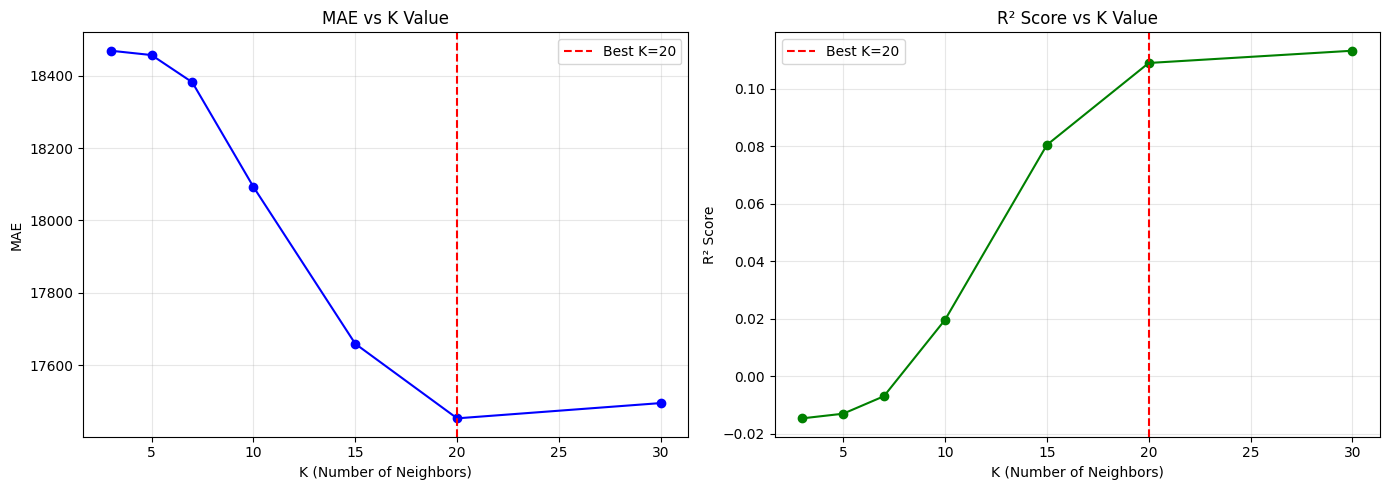

In [34]:
# Plot K value comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['k'], results_df['mae'], marker='o', color='blue')
axes[0].set_xlabel('K (Number of Neighbors)')
axes[0].set_ylabel('MAE')
axes[0].set_title('MAE vs K Value')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(best_k, color='red', linestyle='--', label=f'Best K={int(best_k)}')
axes[0].legend()

axes[1].plot(results_df['k'], results_df['r2'], marker='o', color='green')
axes[1].set_xlabel('K (Number of Neighbors)')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Score vs K Value')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(best_k, color='red', linestyle='--', label=f'Best K={int(best_k)}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Train Final KNN Model with Best K

In [35]:
# Train final model with best K on TRAINING SPLIT ONLY (not full data yet)
print(f"Training final KNN model with K={int(best_k)}...")
final_knn = KNeighborsRegressor(n_neighbors=int(best_k), weights='distance', n_jobs=-1)
final_knn.fit(X_train_split, y_train_split)  # Use SPLIT data, not full data

# Evaluate on validation split
y_pred_val_final = final_knn.predict(X_val_split)
final_mae = mean_absolute_error(y_val_split, y_pred_val_final)
final_rmse = np.sqrt(mean_squared_error(y_val_split, y_pred_val_final))
final_r2 = r2_score(y_val_split, y_pred_val_final)

print(f"\n--- Final KNN Model Results (K={int(best_k)}) ---")
print(f"Validation MAE: {final_mae:.2f}")
print(f"Validation RMSE: {final_rmse:.2f}")
print(f"Validation R²: {final_r2:.4f}")

Training final KNN model with K=20...

--- Final KNN Model Results (K=20) ---
Validation MAE: 17452.60
Validation RMSE: 28790.14
Validation R²: 0.1090

--- Final KNN Model Results (K=20) ---
Validation MAE: 17452.60
Validation RMSE: 28790.14
Validation R²: 0.1090


## 7. Generate Predictions for Test Set

In [36]:
# Now train on FULL training data for final test predictions
print(f"Training on full training data for test predictions...")
final_knn_full = KNeighborsRegressor(n_neighbors=int(best_k), weights='distance', n_jobs=-1)
final_knn_full.fit(X_train_scaled, y_train)
print(f"✓ Model trained on {X_train_scaled.shape[0]} samples")

Training on full training data for test predictions...
✓ Model trained on 95339 samples


In [37]:
# Generate predictions for test set using the full-data model
print("Generating predictions for test set...")
similarity_predictions = final_knn_full.predict(X_test_scaled)

# Create submission dataframe
similarity_submission = pd.DataFrame({
    'ID': test['ID'],
    'Production': similarity_predictions
})

# Ensure predictions are positive
similarity_submission['Production'] = similarity_submission['Production'].clip(lower=0)

print(f"✓ Test predictions generated!")
print(f"Predictions stats: mean={similarity_predictions.mean():.2f}, min={similarity_predictions.min():.2f}, max={similarity_predictions.max():.2f}")
print(f"\nFirst few predictions:")
similarity_submission.head(10)

Generating predictions for test set...
✓ Test predictions generated!
Predictions stats: mean=29672.92, min=815.97, max=393921.00

First few predictions:
✓ Test predictions generated!
Predictions stats: mean=29672.92, min=815.97, max=393921.00

First few predictions:


,ID,Production
0,90,15140.000000
1,16,9769.734532
2,65,43116.696429
3,138,17687.842478
4,166,6868.551448
5,252,50455.118939
6,234,22249.817944
7,306,40482.756997
8,274,84089.273742
9,268,29163.758499


In [38]:
# Save predictions for ensemble
similarity_submission.to_csv('similarity_predictions.csv', index=False)
print("✓ Saved predictions to 'similarity_predictions.csv'")

✓ Saved predictions to 'similarity_predictions.csv'
